In [ ]:
# import the necessary packages
from skimage.segmentation import slic,watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import cv2
import open3d as o3d
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.transform import Rotation as R

import open3d as o3d
import sys

from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-03-12 17:44:17,379 - utils - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2023-03-12 17:44:17,380 - utils - NumExpr defaulting to 8 threads.


# generate 2d cluster points

for now we just do rgb clustering
for further work we can project rgb cloud and sample based on the variance of rgb values

In [10]:
# img_root = "./scene0002_00/every2_replaced_ldr/"
scene_root = "./data/formal_scenes/"
scene_root = "./data/leitest3/"
# scene_name = "scene0001_01/"
hdr_fold = "hdr/"
depth_fold = "depth/"
normal_fold = "normal/"
# cluster_fold = "longtest3clusters/"
cluster_fold = "testroughness/"

===================2frame0370_02===================


5it [00:00, 17.47it/s]

132 centers writen to: ./data/leitest3/2frame0370_02/testroughness/origroughness_6.txt



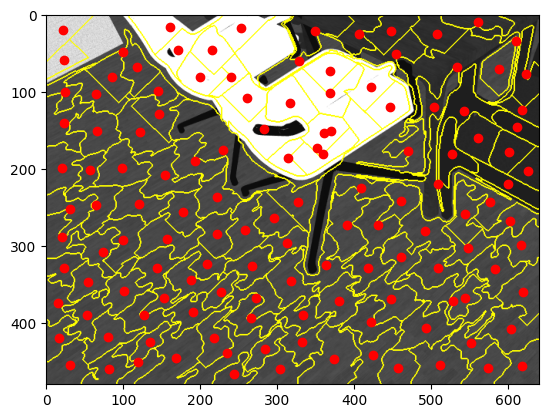

In [15]:
img_start = 5
img_end = 7
img_step = 1 #!!!!

img_idx = list(range(img_start,img_end,img_step))
# img_idx = [10,16]

# numSegments = 64*48 #!!!!
numSegments = 150

folder = "normal/" # change to normal or basecolor or ldr for now
# normal_dirs = os.listdir(normal_root+scene_name)
# folder = "roughness/"

mykey = lambda x:int(x.split(".")[0].split("_")[1])

scene_names = os.listdir(scene_root)

# scene_names = ["scene0370_02"]

for scene_name in scene_names:
    print("==================="+scene_name+"===================")
    scene_name = scene_name + "/"
    
    img_dirs = sorted(os.listdir(scene_root+scene_name+folder),key=mykey)
    
    img_end = min([img_end, len(img_dirs)])
    
    for id_img, img_dir in tqdm(enumerate(img_dirs)):
        
        # if id_img < img_start:
        #     continue
        
        # if id_img >= img_end:
        #     break      
        
        # if not id_img % img_step == 0:
        #     continue
        if not id_img in img_idx:
            continue
        
        if img_dir.split(".")[-1]=="pfm":
            image = cv2.imread(scene_root+scene_name+folder+img_dir, cv2.IMREAD_UNCHANGED)
        else:
            image = img_as_float(io.imread(scene_root+scene_name+folder+img_dir))

        segments = slic(image, n_segments = numSegments, sigma = 3, compactness=1, max_size_factor=1)
        # those look similar share the same envmap, either is really similar or they are robust to different envmaps
        
        numResult = len(set(segments.flatten()))
        centers = np.zeros([numResult,2])
        for s in range(segments.min(), segments.max()+1):
            centers[s-1,:]=np.argwhere(segments==s).mean(axis=0)
        centers = centers.round()
        plt.imshow(mark_boundaries(image, segments))
        break
        plt.scatter(centers[:,1],centers[:,0],marker='o',color='r')
        cluster_path = scene_root + scene_name + cluster_fold
        if not os.path.exists(cluster_path):
            os.mkdir(cluster_path)
        output_path = cluster_path+img_dir.split('.')[0]+".txt"
        print(str(centers.shape[0])+" centers writen to: "+output_path+"\n")
        break
        np.savetxt(output_path,centers,fmt='%d')
    
    break

In [16]:
# raw_mask = cv2.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/pointMask/pointMask_03.png",-1) # without -1 is wrong format!!!!!!!
# h,w,_=raw_mask.shape
# mask_uvs = np.empty([0,2])
# for i in range(h):
#     for w in range(w):
#         if raw_mask[i,w,0] == 255:
#             mask_uvs = np.vstack([mask_uvs,np.array([i,w])])
# mask_uvs
# np.savetxt("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/maskclusters/mask_10.txt",mask_uvs,fmt='%d')
raw_mask = plt.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/pointMask/pointMask_03.png",-1)
mask_uvs = np.argwhere(raw_mask)
np.savetxt("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/maskclusters/mask_10.txt",mask_uvs,fmt='%d')

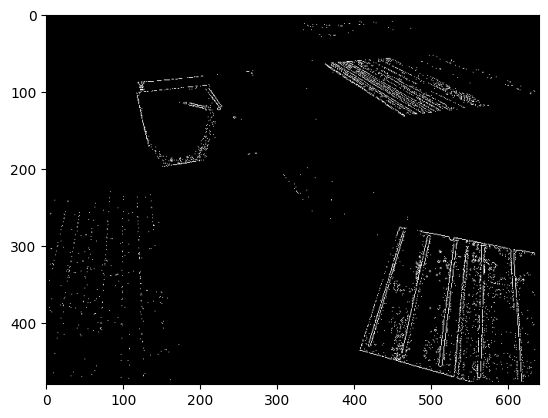

In [17]:
plt.imshow(raw_mask)

# Project the centers and load the result back
Now we use the control points lifted by reduced depth

In [2]:
import numpy as np
import open3d as o3d
import cv2
import os
import sys
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

def gen_local_map_in_world2(depth_img, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=None):
    # lift by the normal image
    fx = intrinsic[0]
    fy = intrinsic[1]
    cx = intrinsic[2]
    cy = intrinsic[3]

    # local_pts_in_world = np.zeros((depth_img.shape[0] * depth_img.shape[1], 3))
    local_pts_in_world = np.empty((0, 3), float)

    # for i in range(depth_img.shape[0]): # row
    #
    #     for j in range(depth_img.shape[1]): # col
    
    if not (normal_img is None):
        normal_img = normal_img[:,:,[2,1,0]]
        # normal_img[:,:,0] = -normal_img[:,:,0]
        # normal_img[:,:,1] = -normal_img[:,:,1]
        # normal_img[:,:,2] = -normal_img[:,:,2]

    for center_id in range(super_pix_centers.shape[0]):

        i = super_pix_centers[center_id, 0] # row id
        j = super_pix_centers[center_id, 1] # col id

        depth = depth_img[i, j]

        if depth == 0:
            continue

        # print(str(depth))

        u = j # col
        v = i # row ?????????


        z = depth / depth_scale

        x = (u - cx) * z / fx

        y = (v - cy) * z / fy

        one_local_pt = [x, y, z]

        # print(str(x) + ' ' + str(y) + ' ' + str(z))

        one_local_pt = np.array(one_local_pt)
        
        if not (normal_img is None):
            nnorm = np.linalg.norm(normal_img[i,j,:])
            one_local_pt -= normal_img[i,j,:]/nnorm*(lift)
        
        one_local_pt = one_local_pt.reshape((3,1))

        t_c2w_ = t_c2w.reshape((3,1))

        pt_only_rot = np.matmul(R_c2w, one_local_pt)
        one_local_pt_in_world = pt_only_rot + t_c2w_

        one_local_pt_in_world = one_local_pt_in_world.reshape((1,3))
        
        # if not (normal_img is None):
        #     one_local_pt_in_world += normal_img[i,j,:]*(lift)

        # one_local_pt_in_world = one_local_pt_in_world.reshape(3)

        # local_pts_in_world[i*depth_img.shape[1] + j, :] = one_local_pt_in_world
        local_pts_in_world = np.append(local_pts_in_world, one_local_pt_in_world, axis=0)

        # local_pts.append(one_local_pt)


    return local_pts_in_world

def convert_depth_to_pcl(depth_image, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers=None, lift_depth=0.0, pts_per=1):
    
    fx = intrinsic[0]
    fy = intrinsic[1]
    cx = intrinsic[2]
    cy = intrinsic[3]
    
    center_x = cx
    center_y = cy

    constant_x = 1 / fx
    constant_y = 1 / fy

    # pointcloud_xzyrgb_fields = [
    #     PointField(name='x', offset=0, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='y', offset=4, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='z', offset=8, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='rgb', offset=12, datatype=PointField.UINT32, count=1)
    # ]

    vs = np.array(
        [(v - center_x) * constant_x for v in range(0, depth_image.shape[1])])
    us = np.array(
        [(u - center_y) * constant_y for u in range(0, depth_image.shape[0])])

    # Convert depth from mm to m.
    depth_image = depth_image / depth_scale - lift_depth

    x = np.multiply(depth_image, vs)
    y = depth_image * us[:, np.newaxis]

    stacked = np.ma.dstack((x, y, depth_image))
    if not (super_pix_centers is None):
        stacked = stacked[super_pix_centers[:,0],super_pix_centers[:,1]]
    compressed = stacked.compressed()
    
    
    pointcloud = compressed.reshape((int(compressed.shape[0] / 3), 3))

    # pointcloud = np.hstack((pointcloud[:, 0:3],
    #                         pack_bgr(*pointcloud.T[3:6])[:, None]))
    # pointcloud = [[point[0], point[1], point[2], point[3]]
    #               for point in pointcloud]

    # pointcloud = pc2.create_cloud(Header(), pointcloud_xzyrgb_fields,
    #                               pointcloud)
    
    H = np.eye(4,4)
    H[:3,:3] = R_c2w
    H[:3,3] = t_c2w
    
    pt = o3d.geometry.PointCloud()
    pt.points = o3d.utility.Vector3dVector(pointcloud)
    pt = pt.transform(H)
    pointcloud = np.asarray(pt.points)
    
    return pointcloud[::pts_per,:]

def convert_depth_to_pcl_normal(depth_image, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers=None, lift=0.0, pts_per=1,normal_image=None):
    fx = intrinsic[0]
    fy = intrinsic[1]
    cx = intrinsic[2]
    cy = intrinsic[3]
    
    center_x = cx
    center_y = cy

    constant_x = 1 / fx
    constant_y = 1 / fy

    # pointcloud_xzyrgb_fields = [
    #     PointField(name='x', offset=0, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='y', offset=4, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='z', offset=8, datatype=PointField.FLOAT32, count=1),
    #     PointField(name='rgb', offset=12, datatype=PointField.UINT32, count=1)
    # ]

    vs = np.array(
        [(v - center_x) * constant_x for v in range(0, depth_image.shape[1])])
    us = np.array(
        [(u - center_y) * constant_y for u in range(0, depth_image.shape[0])])

    # Convert depth from mm to m.
    depth_image = depth_image / depth_scale

    x = np.multiply(depth_image, vs)
    y = depth_image * us[:, np.newaxis]

    stacked = np.ma.dstack((x, y, depth_image))

    if not(normal_image is None):
        norms = np.linalg.norm(normal_image,axis=2)
        norms = np.expand_dims(norms,axis=2)
        norms = np.repeat(norms,3,axis=2)
        ans = normal_image/norms
        stacked += ans*lift

    if not (super_pix_centers is None):
        stacked = stacked[super_pix_centers[:,0],super_pix_centers[:,1]]
    
    compressed = stacked.compressed()
    
    
    pointcloud = compressed.reshape((int(compressed.shape[0] / 3), 3))

    # pointcloud = np.hstack((pointcloud[:, 0:3],
    #                         pack_bgr(*pointcloud.T[3:6])[:, None]))
    # pointcloud = [[point[0], point[1], point[2], point[3]]
    #               for point in pointcloud]

    # pointcloud = pc2.create_cloud(Header(), pointcloud_xzyrgb_fields,
    #                               pointcloud)
    
    H = np.eye(4,4)
    H[:3,:3] = R_c2w
    H[:3,3] = t_c2w
    
    pt = o3d.geometry.PointCloud()
    pt.points = o3d.utility.Vector3dVector(pointcloud)
    pt = pt.transform(H)
    pointcloud = np.asarray(pt.points)
    
    return pointcloud[::pts_per,:]


def read_depthdata(depth_path):
    # load depth data and convert to 16UC1
    with open(depth_path,'rb') as f:
        data = np.fromfile(f,dtype=np.float32)
        data = data[2:] # try drop first 2
        depth = data.reshape([480,640])
    return depth
# plt.imshow(depth_root)

def visual_pts(pts,color=False,frame=True):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts[:,:3])
    if color:
        pcd.colors = o3d.utility.Vector3dVector(pts[:,3:6]/255)       
        
    list_visual = [pcd]
    if frame:
        frames = o3d.geometry.TriangleMesh.create_coordinate_frame()
        list_visual.append(frames)
    o3d.visualization.draw_geometries(list_visual)

def normal_transform(normals_c_oneView,R_c2w):
    a,b,c = normals_c_oneView.shape
    for i in range(a):
        for j in range(b):
            xyz = normals_c_oneView[i,j,:]
            xyz = np.matmul(R_c2w,xyz)
            normals_c_oneView[i,j,:] = xyz
    return normals_c_oneView
    
def lookat2quat(lookat_mat):
    origin = lookat_mat[:3]
    lookat_pts = lookat_mat[3:6]
    up_vec = lookat_mat[6:9]

    H = np.identity(4)

    camera_w = (lookat_pts-origin)/np.linalg.norm(lookat_pts-origin)

    camera_up = up_vec - np.dot(up_vec,camera_w)*camera_w
    camera_up = camera_up/np.linalg.norm(camera_up)

    camera_right = np.cross(camera_w,camera_up)
    camera_right = camera_right/np.linalg.norm(camera_right)

    H[:3,3] = origin
    H[:3,0] = camera_right
    H[:3,1] = -camera_up
    H[:3,2] = camera_w

    R_c2w = H[:3,:3]
    quat = R.from_matrix(R_c2w).as_quat()
    quat = np.array([quat[3],quat[0],quat[1],quat[2]]) # scalar first!!!!!
    return np.hstack([quat,origin])

def get_all_uvs(h,w):
    xs = np.array(list(range(0,h,10)))
    ys = np.array(list(range(0,w,10)))
    xxs, yys = np.meshgrid(xs,ys)
    return np.array([xxs.flatten(),yys.flatten()]).T
get_all_uvs(480,640)
## test with rendering poses
# origin = np.array([-1.726888, -0.224992, 1.240625])
# lookat_pts = np.array([-2.1865239144921595, -0.7589694874667879, 1.950274821382076])
# up_vec = np.array([-0.31294764223241284, 0.8451875066551581, 0.4332687985710611])
# lookat_mat = np.hstack([origin,lookat_pts,up_vec])
# lookat2quat(lookat_mat) # # array([-0.2758599 , -0.2628239 ,  0.92005167, -0.09126797, -1.726888  , -0.224992  ,  1.240625  ])

array([[  0,   0],
       [ 10,   0],
       [ 20,   0],
       ...,
       [450, 630],
       [460, 630],
       [470, 630]])

In [11]:
print(sys.path)

# scenes_root = "./data/formal_scenes/"
scenes_root = "./data/short_scenes/"
# pose_root = "./data/poses_per2frame/every2frame/"
pose_root = "./data/short_poses/"
# output_root = "./output/lookats_control_point_normal/"
# output_root = "./output/lei_control_points3knormal/"
# output_root = "./output/masknolift_control_points/"
output_root = "./output/leitest2/"

# output_folder = './output_cam_file/'

# scene_names_path = '/storage/user/lhao/hjp/ws_superpixel/haoang_control_pts/scene_names_demo.txt' # !!!!!!!!!!!!!!!!!!!!!!! TO adjust
# center_fold = "testclusters/"
# center_fold = "leiclusters/"
center_fold = "leicluster2/"

depth_fold = "depth/"
normal_fold = "normal/"

depth_scale = 1  # ??????????
# intrinsic = [577.591, 578.73, 318.905, 242.684] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# intrinsic = [222.22, 222.22, 160, 120]
intrinsic = [577.8705679012345,577.8705679012345,320,240]

# lift = 0.005 #!!!!!!
lift = 0.0

TEST_ALL_UVS = True
USE_WORLD_CAM = True

scene_names = os.listdir(scenes_root)

scene_names = ["scene0370_02"]
# scene_names = ["scene0704_01"]

# scene_idx = 0
for scene_idx, scene_name in enumerate(scene_names):
    # scene_name = scene_name.rstrip()
    
    scene_path = scenes_root + scene_name

    # img poses
    poses_path = pose_root + scene_name + '.txt'
    # poses_path = 'haoang_process_results/' + scene_name + '.txt'

    # with open(poses_path) as f_poses:
    #     poses = f_poses.readlines()
    poses = np.loadtxt(poses_path)

    output_folder = output_root + scene_name + '/'
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    pts_in_world_all_mulView = np.empty((0, 9), float)
    
    mykey = lambda x:int(x.split(".")[0].split("_")[1])
    
    depth_all_names = sorted(os.listdir(os.path.join(scene_path, depth_fold)),key=mykey)
    center_all_names = sorted(os.listdir(os.path.join(scene_path, center_fold)),key=mykey)
    normal_all_names = sorted(os.listdir(os.path.join(scene_path, normal_fold)),key=mykey)
    
    depth_prefix = depth_all_names[0].split('_')[0]
    depth_format = depth_all_names[0].split('.')[-1]
    
    normal_prefix = normal_all_names[0].split('_')[0]

    # pts_in_world_all_mulView = np.ones((len(depth_all_names),3),float)
    if TEST_ALL_UVS:
        pts_all = np.empty((0,3))

    # center_all_names = ['bgrnormal_11.txt'] #!!!!!!
    for center_name in center_all_names:

        pose_idx = int(center_name.split(".")[0].split("_")[1])

        # depth_name = depth_all_names[pose_idx-1]
        depth_name = depth_prefix+("_{}.".format(pose_idx))+depth_format

        # normal_name = normal_all_names[pose_idx-1]
        normal_name = normal_prefix+("_{}.pfm".format(pose_idx))

        # break
        depth_path = os.path.join(os.path.join(scene_path, depth_fold, depth_name))
        
        center_path = os.path.join(os.path.join(scene_path, center_fold, center_name))
        
        normal_path = os.path.join(os.path.join(scene_path, normal_fold, normal_name))
        
        if depth_path.split(".")[-1]=="png":
            depth_all = cv2.imread(depth_path,cv2.CV_16UC1)/5000.0
        else:
            depth_all = read_depthdata(depth_path)
        
        
        # pose = poses[pose_idx].rstrip()
        # pose = pose.split(' ')
        # pose = list(map(float, pose))

        pose = poses[pose_idx-1,:]
        print("center:{} with pose:{}".format(str(center_name),str(pose)))
        
        if TEST_ALL_UVS:
            # if (pose_idx != 10) and (pose_idx!=14): # !!!!
            #     continue
            print(pose)

        q_c2w = [pose[1], pose[2], pose[3], pose[0]]
        q_c2w = np.array(q_c2w)
        # q_c2w = q_c2w.reshape((1, 4))
        r_c2w = R.from_quat(q_c2w)
        R_c2w = r_c2w.as_matrix()

        t_c2w = pose[4:7]
        t_c2w = np.array(t_c2w)
        
        normals_c_oneView = cv2.imread(normal_path,cv2.IMREAD_UNCHANGED)
        normals_c_oneView = 2*normals_c_oneView-1
        # break
        super_pix_centers = np.loadtxt(center_path,dtype=np.int32)
        # break
        
        if TEST_ALL_UVS:
            pts_oneView = convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w)
            np.savetxt(os.path.join(output_folder,"pts_oneView.txt"),pts_oneView)
            pts_all = np.append(pts_all, pts_oneView,axis=0)
            # continue
        
        # origin_in_world_oneView = gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=normals_c_oneView)

        # origin_in_world_oneView = convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift_depth=lift)
        normals_c_oneView = normals_c_oneView[:,:,[2,1,0]]
        normals_c_oneView[:,:,1] = -normals_c_oneView[:,:,1]
        normals_c_oneView[:,:,2] = -normals_c_oneView[:,:,2]
        origin_in_world_oneView = convert_depth_to_pcl_normal(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=lift,normal_image=normals_c_oneView)
        # origin_in_world_oneView = convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers=super_pix_centers, lift_depth=lift,pts_per=100)
        np.savetxt(os.path.join(output_folder,"origin_in_world_oneView.txt"),origin_in_world_oneView)
        if USE_WORLD_CAM:
            lookat_in_world_oneView = origin_in_world_oneView + np.array([0,0,1])
            up_vectors_oneView = np.zeros_like(origin_in_world_oneView)
            up_vectors_oneView[:,1] = 1
        else:
            # lookat_in_world_oneView =  gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=2*lift, normal_img=normals_c_oneView)
            lookat_in_world_oneView = convert_depth_to_pcl(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift_depth=3*lift)
            up_vectors_oneView = np.zeros_like(lookat_in_world_oneView)
            up_vectors_oneView[:,2] = 1

        pts_in_world_all_oneView = np.hstack([origin_in_world_oneView, lookat_in_world_oneView, up_vectors_oneView])

        pts_in_world_all_mulView = np.append(pts_in_world_all_mulView, pts_in_world_all_oneView, axis=0)

        print('Complete pose ' + str(pose_idx) + '/' + str(len(depth_all_names)) + ', scene ' + str(scene_idx + 1) + '/' + str(len(scene_names)))

        # pose_idx = pose_idx + 1
        # break
    output_path_all_mulView = os.path.join(output_folder, scene_name+'_control_cam.txt')
    # break
    if TEST_ALL_UVS:
        np.savetxt(os.path.join(output_folder,scene_name+'test_all_uvs.txt'),pts_all, header='#x y z')
        # continue
    
    output_quats_mulView = np.zeros([len(pts_in_world_all_mulView),7])
    for id,lookat_mat in enumerate(pts_in_world_all_mulView):
        output_quats_mulView[id,:] = lookat2quat(lookat_mat)
    np.savetxt(os.path.join(output_folder, scene_name+'_control_cam_pose.txt'), output_quats_mulView, header='# qw qx qy qz x y z') #!!!!
    
    with open(output_path_all_mulView, 'w') as f_output_path_all_mulView:
        num = pts_in_world_all_mulView.shape[0]
        f_output_path_all_mulView.write( str(num) + '\n')
        for i in range(num):
            # if not i%10==0:
            #     continue
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][0]) + ' ' + str(pts_in_world_all_mulView[i][1]) + ' ' + str(
                pts_in_world_all_mulView[i][2]) + '\n')
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][3]) + ' ' + str(pts_in_world_all_mulView[i][4]) + ' ' + str(
                pts_in_world_all_mulView[i][5]) + '\n')
            f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][6]) + ' ' + str(pts_in_world_all_mulView[i][7]) + ' ' + str(
                pts_in_world_all_mulView[i][8]) + '\n')
    
    # np.savetxt(output_path_all_mulView, pts_in_world_all_mulView)
    # break
    print('Comelete Scene ' + str(scene_idx + 1) + '/' + str(len(scene_names)) )
    print('===================================================')


['/storage/user/lhao/hjp/ws_superpixel', '/usr/wiss/lhao/anaconda3/envs/open3d37/lib/python37.zip', '/usr/wiss/lhao/anaconda3/envs/open3d37/lib/python3.7', '/usr/wiss/lhao/anaconda3/envs/open3d37/lib/python3.7/lib-dynload', '', '/usr/wiss/lhao/anaconda3/envs/open3d37/lib/python3.7/site-packages', '/usr/wiss/lhao/anaconda3/envs/open3d37/lib/python3.7/site-packages/IPython/extensions', '/home/wiss/lhao/.ipython']
center:lei_2.txt with pose:[ 0.29155185  0.87242674 -0.1240162   0.37214122 -2.228       0.291
  0.458     ]
[ 0.29155185  0.87242674 -0.1240162   0.37214122 -2.228       0.291
  0.458     ]
Complete pose 2/6, scene 1/1
Comelete Scene 1/1


now we can visualize our result, green for lookat points and red for camera origins

In [7]:
# np.savetxt("pts_all.txt",pts_all)
# pts_all = np.loadtxt("pts_all.txt")
np.savetxt(output_folder + scene_name+"origins.txt", pts_in_world_all_mulView[:,:3])
np.savetxt(output_folder + scene_name+"lookats.txt", pts_in_world_all_mulView[:,3:6])

In [11]:
pt_all = o3d.geometry.PointCloud()
pt_all.points = o3d.utility.Vector3dVector(pts_all)
pt_all.paint_uniform_color(np.array([0.5,0.5,0.5]))
frames = o3d.geometry.TriangleMesh.create_coordinate_frame()
o3d.visualization.draw_geometries([frames,pt_all])

In [7]:
pt_origins = o3d.geometry.PointCloud()
pt_origins.points = o3d.utility.Vector3dVector(pts_in_world_all_mulView[:,:3])
pt_origins.paint_uniform_color(np.array([1,0,0]))

pt_lookats = o3d.geometry.PointCloud()
pt_lookats.points = o3d.utility.Vector3dVector(pts_in_world_all_mulView[:,3:6])
pt_lookats.paint_uniform_color(np.array([0,1,0]))

# pt_cams = o3d.geometry.PointCloud()
# pt_cams.points = o3d.utility.Vector3dVector(poses[list(range(img_start,img_end,img_step)),4:7])
# pt_cams.paint_uniform_color(np.array([0,0,1]))

pt_all = o3d.geometry.PointCloud()
pt_all.points = o3d.utility.Vector3dVector(pts_all)
pt_all.paint_uniform_color(np.array([0.5,0.5,0.5]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame()

o3d.visualization.draw_geometries([pt_lookats,pt_origins,frame],point_show_normal=True)


In [ ]:
pt_origins

# Devel and Debug

## Short scenes scene0370_02

In [28]:
intrinsic = [577.8705679012345,577.8705679012345,320,240]
lift = 0.0
depth_scale = 1

scene_name = "short0370_02"

output_folder = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/output"
# center_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/point_of_Interest.txt"
center_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/clusters/bgr_2.txt"
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/depth/origdepth_2.png"
normal_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/normal/orignormal_2.pfm"

pts_in_world_all_mulView = np.empty((0, 9), float)
pts_all = np.empty((0,3))

depth_all = cv2.imread(depth_path,cv2.CV_16UC1)/5000.0

raw_pose = np.array([2.915518455604547698e-01,8.724267396286820020e-01,-1.240161990092776972e-01,3.721412201227538019e-01,-2.228000000000000203e+00,2.909999999999999809e-01,4.580000000000000182e-01])
q_c2w = raw_pose[[1,2,3,0]]
r_c2w = R.from_quat(q_c2w)
R_c2w = r_c2w.as_matrix()
t_c2w = raw_pose[-3:]

normals_c_oneView = cv2.imread(normal_path,cv2.IMREAD_UNCHANGED)
normals_c_oneView = 2*normals_c_oneView-1
normals_c_oneView = normals_c_oneView[:,:,[2,1,0]]
normals_c_oneView[:,:,1] = -normals_c_oneView[:,:,1]
normals_c_oneView[:,:,2] = -normals_c_oneView[:,:,2]

super_pix_centers = np.loadtxt(center_path, dtype=np.int32)

pts_oneView = convert_depth_to_pcl_normal(depth_all, intrinsic, depth_scale, R_c2w, t_c2w)
pts_all = np.append(pts_all,pts_oneView,axis=0)

origin_in_world_oneView = convert_depth_to_pcl_normal(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=lift,normal_image=normals_c_oneView)
lookat_in_world_oneView = origin_in_world_oneView + np.array([0,0,1])
up_vectors_oneView = np.zeros_like(origin_in_world_oneView)
up_vectors_oneView[:,1] = 1

pts_in_world_all_oneView = np.hstack([origin_in_world_oneView, lookat_in_world_oneView, up_vectors_oneView])
pts_in_world_all_mulView = np.append(pts_in_world_all_mulView, pts_in_world_all_oneView, axis=0)

np.savetxt(os.path.join(output_folder,scene_name+'test_all_uvs.txt'),pts_all, header='#x y z')
np.savetxt(os.path.join(output_folder,scene_name+'origin.txt'),origin_in_world_oneView, header='#x y z')

output_quats_oneView = np.zeros([len(pts_in_world_all_oneView),7])
for id,lookat_mat in enumerate(pts_in_world_all_oneView):
    output_quats_oneView[id,:] = lookat2quat(lookat_mat)
np.savetxt(os.path.join(output_folder, scene_name+'_control_cam_pose.txt'), output_quats_oneView, header='# qw qx qy qz x y z') #!!!!

output_path_all_mulView = os.path.join(output_folder,scene_name+"_control_cam.txt")
with open(output_path_all_mulView, 'w') as f_output_path_all_mulView:
    num = pts_in_world_all_mulView.shape[0]
    f_output_path_all_mulView.write( str(num) + '\n')
    for i in range(num):
        # if not i%10==0:
        #     continue
        f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][0]) + ' ' + str(pts_in_world_all_mulView[i][1]) + ' ' + str(
            pts_in_world_all_mulView[i][2]) + '\n')
        f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][3]) + ' ' + str(pts_in_world_all_mulView[i][4]) + ' ' + str(
            pts_in_world_all_mulView[i][5]) + '\n')
        f_output_path_all_mulView.write(str(pts_in_world_all_mulView[i][6]) + ' ' + str(pts_in_world_all_mulView[i][7]) + ' ' + str(
            pts_in_world_all_mulView[i][8]) + '\n')
        

In [32]:
np.savetxt(os.path.join(output_folder,scene_name+"origins.txt"), pts_in_world_all_mulView[:,:3])
np.savetxt(os.path.join(output_folder,scene_name+"lookats.txt"), pts_in_world_all_mulView[:,3:6])

In [3]:
pts_load = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/data/shortscenes0370_02/output/short0370_02test_all_uvs.txt")
visual_pts(pts_load)

In [30]:
pt_origin = o3d.geometry.PointCloud()
pt_origin.points = o3d.utility.Vector3dVector(pts_in_world_all_mulView[:,:3])
pt_origin.paint_uniform_color(np.array([1,0,0]))

pt_all = o3d.geometry.PointCloud()
pt_all.points = o3d.utility.Vector3dVector(pts_all)
pt_all.paint_uniform_color(np.array([0.1,0.1,0.1]))
frames = o3d.geometry.TriangleMesh.create_coordinate_frame()
o3d.visualization.draw_geometries([frames,pt_all,pt_origin])

## Debug for normal direction

In [15]:
# single frame checking
normal_path = "/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/normal/bgrnormal_1.pfm"
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/depth/origfovdepth_1.dat"

depth_scale = 1  # ??????????
# intrinsic = [577.591, 578.73, 318.905, 242.684] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# intrinsic = [222.22, 222.22, 160, 120]
intrinsic = [577.8705679012345,577.8705679012345,320,240]

lift = 0.005 #!!!!!!

R_c2w = np.eye(3,3)
t_c2w = np.array([0,0,0])

normals_c_oneView = cv2.imread(normal_path, cv2.IMREAD_UNCHANGED)
normals_c_oneView = 2*normals_c_oneView-1
# normals_c_oneView = plt.imread(normal_path)
print(normal_path)

# depth_all = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
depth_all = read_depthdata(depth_path)
print(depth_path)

lift = 0.005

# origin_in_world_oneView = gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=0, normal_img=normals_c_oneView)

origin_in_world_oneView = convert_depth_to_pcl_normal(depth_all,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers=None, lift=lift, normal_image=None)

# lookat_in_world_oneView =  gen_local_map_in_world2(depth_all, intrinsic, depth_scale, R_c2w, t_c2w, super_pix_centers, lift=2*lift, normal_img=normals_c_oneView)

lookat_in_world_oneView = convert_depth_to_pcl_normal(depth_all,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers=None,lift=3*lift, normal_image=None)

# pt_all = convert_depth_to_pcl(depth_all,intrinsic, depth_scale, R_c2w, t_c2w)

pt_origins = o3d.geometry.PointCloud()
pt_origins.points = o3d.utility.Vector3dVector(origin_in_world_oneView)
normals = normals_c_oneView[:,:,[2,1,0]]
# normals[:,:,0] = -normals[:,:,0]
normals[:,:,1] = -normals[:,:,1]
normals[:,:,2] = -normals[:,:,2]

pt_origins.normals = o3d.utility.Vector3dVector(normals.reshape(480*640,3))
pt_origins.paint_uniform_color(np.array([1,0,0]))

pt_lookats = o3d.geometry.PointCloud()
pt_lookats.points = o3d.utility.Vector3dVector(lookat_in_world_oneView)
pt_lookats.paint_uniform_color(np.array([0,1,0]))

# pt_cams = o3d.geometry.PointCloud()
# pt_cams.points = o3d.utility.Vector3dVector(poses[list(range(img_start,img_end,img_step)),4:7])
# pt_cams.paint_uniform_color(np.array([0,0,1]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame()

o3d.visualization.draw_geometries([pt_origins,frame],point_show_normal=True)

/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/normal/bgrnormal_1.pfm
/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/depth/origfovdepth_1.dat


In [31]:
normals.astype(np.single).tofile("normals.data")

In [ ]:
normals_c_oneView = cv2.imread(normal_path, cv2.IMREAD_UNCHANGED)

In [33]:
leinormal_path = "/storage/user/lhao/hjp/ws_superpixel/data/leiNormal.pfm"
leinormal = cv2.imread(leinormal_path, cv2.IMREAD_UNCHANGED)
orgnormal_path = "/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/normal/bgrnormal_1.pfm"
orgnormal = cv2.imread(orgnormal_path, cv2.IMREAD_UNCHANGED)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


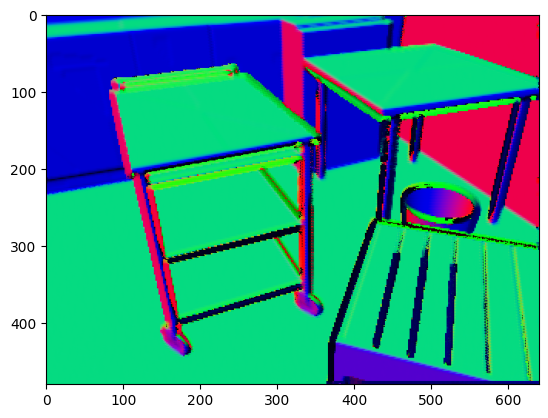

In [34]:
plt.imshow(leinormal[:,:,[2,1,0]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


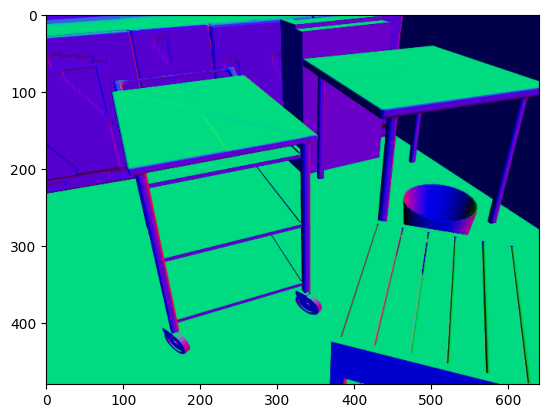

In [35]:
plt.imshow(orgnormal[:,:,[2,1,0]]*2-1)

In [10]:
def rigid_transform_3D(A, B):
    assert len(A) == len(B)
    N = A.shape[0]
    mu_A = np.mean(A, axis=0)
    mu_B = np.mean(B, axis=0)

    AA = A - np.tile(mu_A, (N, 1))
    BB = B - np.tile(mu_B, (N, 1))
    H = np.matmul(np.transpose(AA),BB)

    U, S, Vt = np.linalg.svd(H)
    R = np.matmul(Vt.T , U.T)

    if np.linalg.det(R) < 0:
        print("Reflection detected")
        Vt[2, :] *= -1
        R = np.matmul(Vt.T, U.T)

    t = np.matmul(-R, mu_A.T) + mu_B.T

    return R, t

R, t = rigid_transform_3D(leinormal.reshape(640*480,3),orgnormal.reshape(640*480,3))

Reflection detected


In [13]:
np.matmul(R,leinormal.reshape(640*480,3).T)

(3, 307200)

In [12]:
depth_all = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
# depth_all = read_depthdata(depth_path)
depth_all

In [522]:
stacked[super_pix_centers[:,0],super_pix_centers[:,1]].shape

(555, 3)

In [504]:
visual_pts(lookat_in_world_oneView-origin_in_world_oneView)

In [503]:
np.savetxt("./origin.txt",origin_in_world_oneView)
np.savetxt("./lookat.txt",lookat_in_world_oneView)

In [500]:
cv2.imread(normal_path)/255.0

array([[[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       [[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       [[0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        [0.64313725, 0.45490196, 0.97647059],
        ...,
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ],
        [0.92156863, 0.29411765, 0.3254902 ]],

       ...,

       [[0.70588235, 0.95294118, 0.47843137],
        [0.70588235, 0.95294118, 0.47843137],
        [0.70588235, 0

In [484]:
# 518 544 relative pose
id0 = 518
id1 = 544

pose0 = poses[id0-1,:]
pose1 = poses[id1-1,:]

q_c2w0 = [pose0[1], pose0[2], pose0[3], pose0[0]]
q_c2w0 = np.array(q_c2w0)
# q_c2w = q_c2w.reshape((1, 4))
r_c2w0 = R.from_quat(q_c2w0)
R_c2w0 = r_c2w0.as_matrix()

t_c2w0 = pose0[4:7]
t_c2w0 = np.array(t_c2w0)

H0 = np.eye(4,4)
H0[:3,:3] = R_c2w0
H0[:3,3] = t_c2w0

q_c2w1 = [pose1[1], pose1[2], pose1[3], pose1[0]]
q_c2w1 = np.array(q_c2w1)
# q_c2w = q_c2w.reshape((1, 4))
r_c2w1 = R.from_quat(q_c2w1)
R_c2w1 = r_c2w1.as_matrix()

t_c2w1 = pose1[4:7]
t_c2w1 = np.array(t_c2w1)

H1 = np.eye(4,4)
H1[:3,:3] = R_c2w1
H1[:3,3] = t_c2w1

img_norm0 = plt.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0001_01/normal/origfovnormal_518.png")
img_norm1 = plt.imread("/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0001_01/normal/origfovnormal_544.png")

norm0 = img_norm0[0,0,:]
norm0 = norm0/np.linalg.norm(norm0)
norm1 = img_norm1[0,0,:]
norm1 = norm1/np.linalg.norm(norm1)

print(norm0)
print(norm1)

Rt = np.matmul(R_c2w1.T,R_c2w0)

print(np.matmul(Rt,norm0))


[0.7182868  0.27056545 0.6409824 ]
[0.54478073 0.19583622 0.81539077]
[0.87412507 0.45513754 0.1695736 ]


In [485]:
print(np.matmul(R_c2w0,norm0))
print(np.matmul(R_c2w1,norm1))

[-0.66267637 -0.41865606  0.62095665]
[ 0.06491376 -0.59317218  0.80245432]


In [483]:
print(img_norm0[479,639,:])
print(img_norm1[479,639,:])

[0.5529412  0.9529412  0.69411767]
[0.5254902  0.9098039  0.78431374]


In [478]:
norm0

array([0.8745098 , 0.32941177, 0.78039217], dtype=float32)

In [479]:
norm1

array([0.6       , 0.21568628, 0.8980392 ], dtype=float32)

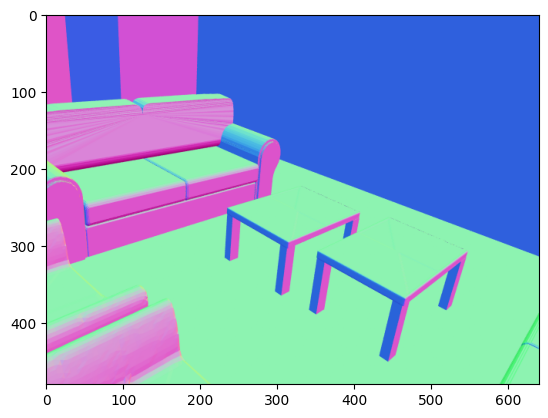

In [475]:
plt.imshow(img_norm0)

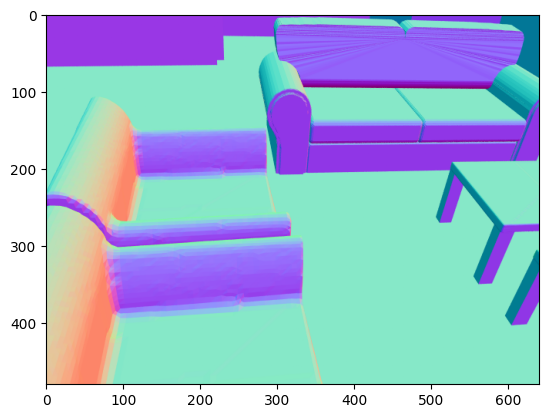

In [476]:
plt.imshow(img_norm1)

In [23]:
test_xyz = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/lookats_control_point/scene0001_01/scene0001_01test_xyz.txt")
control_poses = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/lookats_control_point/scene0001_01/scene0001_01_control_cam_pose.txt")
# visual_pts(test_xyz[:,4:],color=False)
# test_xyz = test_xyz[:,4:]
# visual_pts(test_xyz,color=False)
# visual_pts(pts_in_world_all_mulView[:,:3],color=False)

In [41]:
# output_quats_mulView = np.zeros([len(pts_in_world_all_mulView),7])
# for id,lookat_mat in enumerate(pts_in_world_all_mulView):
#     output_quats_mulView[id,:] = lookat2quat(lookat_mat)
# np.savetxt(output_folder + scene_name + '_control_cam_pose' +'.txt',output_quats_mulView, header='qw qx qy qz x y z')

## Get the lookats back to quaternionxyz format 
short0370_02

In [27]:
len(pts_in_world_all_mulView)
# test with scene0704_01 cam 0
# origin = np.array([-1.04351, 0.11368, -1.488205])
# lookat_pts = np.array([-0.6426136504334944, -0.3941807690846877, -0.7257356195466208])
# up_vec = np.array([0.21536858923208257, 0.861198667470616, 0.4603837811207274])
# # array([ 0.22818896, -0.25825396,  0.93729885,  0.05201499, -1.04351   ,0.11368   , -1.488205  ])
# # test passed!!!!

1269

In [9]:
# test for 3frame370_02
cam0370 = np.loadtxt("/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/cam.txt")
cam0370 = cam0370.reshape([-1,9])
lookat_mats = cam0370

In [11]:
# lookat_mat = pts_in_world_all_mulView[0]
origin = lookat_mat[:3]
lookat_pts = lookat_mat[3:6]
up_vec = lookat_mat[6:9]

H = np.identity(4)

camera_w = (lookat_pts-origin)/np.linalg.norm(lookat_pts-origin)

camera_up = up_vec - np.dot(up_vec,camera_w)*camera_w
camera_up = camera_up/np.linalg.norm(camera_up)

camera_right = np.cross(camera_w,camera_up)
camera_right = camera_right/np.linalg.norm(camera_right)

H[:3,3] = origin
H[:3,0] = camera_right
H[:3,1] = -camera_up
H[:3,2] = camera_w

R_c2w = H[:3,:3]
quat = R.from_matrix(R_c2w).as_quat()
np.hstack([quat,origin])

array([ 0.95984285,  0.01682463, -0.06002252,  0.273525  ,  3.083     ,
        0.578     , -0.072     ])

In [11]:
# def lookat2quat(lookat_mat):
#     origin = lookat_mat[:3]
#     lookat_pts = lookat_mat[3:6]
#     up_vec = lookat_mat[6:9]

#     H = np.identity(4)

#     camera_w = (lookat_pts-origin)/np.linalg.norm(lookat_pts-origin)

#     camera_up = up_vec - np.dot(up_vec,camera_w)*camera_w
#     camera_up = camera_up/np.linalg.norm(camera_up)

#     camera_right = np.cross(camera_w,camera_up)
#     camera_right = camera_right/np.linalg.norm(camera_right)

#     H[:3,3] = origin
#     H[:3,0] = camera_right
#     H[:3,1] = -camera_up
#     H[:3,2] = camera_w

#     R_c2w = H[:3,:3]
#     quat = R.from_matrix(R_c2w).as_quat()
#     quat = quat[[3,0,1,2]]
#     return np.hstack([quat,origin]) # w x y z

cam_poses_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/cam_pose.txt"
cam_poses = np.zeros([len(lookat_mats),7])
for id,lookat_mat in enumerate(lookat_mats):
    cam_poses[id,:] = lookat2quat(lookat_mat)
    print(lookat2quat(lookat_mat))
np.savetxt(cam_poses_path,cam_poses,header="qw qx qy qz x y z")

[ 0.02240354  0.60178675 -0.02947304  0.7977983  -4.59        0.459
 -1.744     ]
[ 0.29155185  0.87242674 -0.1240162   0.37214122 -2.228       0.291
  0.458     ]
[ 0.30701675  0.87867321 -0.14240183  0.33674298 -2.128       0.291
  0.458     ]
[ 0.32405767  0.88404635 -0.16077217  0.29597464 -2.028       0.291
  0.458     ]
[ 0.34222455  0.88815396 -0.17832079  0.24953277 -1.928       0.291
  0.458     ]
[ 0.36071571  0.89062325 -0.19407144  0.19751121 -1.828       0.291
  0.458     ]
[ 0.0731163   0.50816828 -0.12214231  0.84941171 -2.944       0.57
 -1.947     ]
[-0.0118173  -0.51297121 -0.01973581  0.85809754  3.294       0.415
 -2.189     ]
[ 0.23423546  0.90061744 -0.09200938  0.35433916 -2.347       0.484
 -0.188     ]
[ 0.03755223  0.62641543 -0.04686722  0.77717244 -5.207       0.388
 -1.683     ]
[-0.02210113 -0.41602889 -0.0482705   0.90780034  2.265       0.441
 -2.003     ]
[-0.01352604 -0.44358469 -0.02790605  0.89569578  2.453       0.503
 -2.025     ]
[ 0.05032155  0.8

In [12]:
lookat_mat = np.array([0,0,0,0,0,1,0,1,0])
lookat2quat(lookat_mat)

array([0., 0., 0., 1., 0., 0., 0.])

In [3]:
# check the direction of the normals is alon the optical axis of the camera

# np.savetxt("lift.txt", pts_in_world_all_oneView_lifted)
# np.savetxt("nolift.txt", pts_in_world_all_oneView)

In [13]:
# plt.imshow(normals_c_oneView)
# a,b,c = normals_c_oneView.shape
# for i in range(a):
#     for j in range(b):
#         xyz = normals_c_oneView[i,j,:]
#         xyz = np.matmul(R_c2w,xyz)
#         normals_c_oneView[i,j,:] = xyz
# plt.imshow(normals_c_oneView)

In [14]:
xyz = normals_c_oneView[100,600,:]
xyz.dot(np.array([0,0,1]))

0.729411780834198

In [7]:
visual_pts(pts_in_world_all_mulView, color=False)

## Convert PFM normal to data format

In [13]:
def normalpfm2data(pfm):
    normals_c_oneView = 2*pfm-1
    normals = normals_c_oneView[:,:,[2,1,0]]
    # normals[:,:,0] = -normals[:,:,0]
    normals[:,:,1] = -normals[:,:,1]
    normals[:,:,2] = -normals[:,:,2]
    return normals

pfm_normal_paths = "/storage/user/lhao/hjp/ws_superpixel/data/2frame0370_02/normal"
data_normal_paths = "/storage/user/lhao/hjp/ws_superpixel/data/2frame0370_02/normal_data"

for pfm_normal_path in sorted(os.listdir(pfm_normal_paths)):
    pfm = cv2.imread(os.path.join(pfm_normal_paths,pfm_normal_path), cv2.IMREAD_UNCHANGED)
    normals = normalpfm2data(pfm)
    data_normal_path = pfm_normal_path.replace(".pfm",".dat")
    normals.astype(np.single).tofile(os.path.join(data_normal_paths,data_normal_path))
    

In [4]:
pfm_normal_path.replace(".pfm",".dat")

'orignormal_1.dat'

## Load trajectory

In [20]:
# traj_path = './sparse30/scene0002_00gt.txt'
# # lookat_path = './sparse30/scene0002_00lookat.txt'
# r = np.loadtxt(traj_path)
# rsparse = r[0:150:30]
# np.savetxt('./sparse30/sparse30.txt',rsparse)

In [39]:
# traj_path = './sparse30/scene0001_00gt.txt'
# # lookat_path = './sparse30/scene0002_00lookat.txt'
# r = np.loadtxt(traj_path)
# rsparse = r[0::100]
# np.savetxt('./sparse30/scene0001_00.txt',rsparse)
# rsparse.shape

(9, 7)

In [31]:
traj_path = "./sparse30/scene0002_00.txt"
traj = np.loadtxt(traj_path)
traj

array([[-1.340000e-04, -2.479700e-01, -2.449100e-01,  9.372990e-01,
         1.424611e+00,  7.543500e-02, -4.338040e-01],
       [-5.742100e-02, -3.586660e-01, -2.337940e-01,  9.018880e-01,
         1.389048e+00,  7.894000e-02, -4.764700e-02],
       [-1.910430e-01, -5.660010e-01, -1.943450e-01,  7.780590e-01,
         1.311833e+00,  1.101250e-01,  3.972050e-01],
       [ 1.914100e-01,  7.866610e-01,  8.648400e-02, -5.805580e-01,
         1.145395e+00,  1.473280e-01,  6.533280e-01],
       [ 2.717670e-01,  9.006210e-01, -2.166000e-03, -3.391450e-01,
         8.602110e-01,  1.778700e-01,  4.751650e-01]])

## Load pfm

In [20]:
ans = cv2.imread("/storage/user/lhao/hjp/ws_superpixel/formal_scenes/scene0001_01/pfm/origfov_1.pfm",cv2.IMREAD_UNCHANGED)
cv2.imshow('test',ans)
cv2.waitKey(0)
cv2.destroyAllWindows() # press q
# ans[ans.nonzero()]

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread (0x628bef0).
Cannot move to target thread (0x57bd660)

QObject::moveToThread: Current thread (0x57bd660) is not the object's thread

## Single frame point cloud up vector test
old function gen and new function convert

new function

In [16]:
intrinsic = [577.8705679012345,577.8705679012345,320,240]
depth_scale = 1
R_c2w = np.eye(3)
t_c2w = np.zeros(3)
# test for red kitchen
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/depth/origfovdepth_1.dat"
depth_image = read_depthdata(depth_path)
pts_single = convert_depth_to_pcl(depth_image,intrinsic,depth_scale,R_c2w,t_c2w)
np.savetxt("./pts_single.txt",pts_single)
# test for meeting room
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/depth/origdepth_1.png"
depth_image = cv2.imread(depth_path,cv2.CV_16UC1)/5000
pts_single = convert_depth_to_pcl(depth_image,intrinsic,depth_scale,R_c2w,t_c2w)
np.savetxt("./pts_single_meetingroom.txt",pts_single)

old function

In [30]:
intrinsic = [577.8705679012345,577.8705679012345,320,240]
depth_scale = 1
R_c2w = np.eye(3)
t_c2w = np.zeros(3)

uu = np.arange(0,480,10)
vv = np.arange(0,640,10)
super_pix_centers = np.array([[u,v] for u in uu for v in vv])

# test for red kitchen
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/formal_scenes/scene0704_01/depth/origfovdepth_1.dat"
depth_image = read_depthdata(depth_path)
pts_single = gen_local_map_in_world2(depth_image,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers)
np.savetxt("./debug/oldfunc/pts_single_kitchen.txt",pts_single)
# test for meeting room
depth_path = "/storage/user/lhao/hjp/ws_superpixel/data/short_scenes/scenes0370_02/depth/origdepth_1.png"
depth_image = cv2.imread(depth_path,cv2.CV_16UC1)/5000
pts_single = gen_local_map_in_world2(depth_image,intrinsic,depth_scale,R_c2w,t_c2w,super_pix_centers)
np.savetxt("./debug/oldfunc/pts_single_meetingroom.txt",pts_single)

In [27]:
uu = np.arange(480)
vv = np.arange(640)
np.array([[u,v] for u in uu for v in vv])

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [479, 637],
       [479, 638],
       [479, 639]])

# FOV

In [ ]:
intrinsic = [2*222.22, 2*222.22, 640, 480]

In [7]:
2*np.arctan(640/2/444.44)/np.pi*180

71.50831788654655

In [10]:
2*np.arctan(1296/2/1170.1879)/np.pi*180

57.95161640727124

In [11]:
2*np.arctan(320/2/222.2)/np.pi*180

71.51320860769698

In [19]:
640/1296*1170.1879

577.8705679012345

In [20]:
2*np.arctan(640/2/577.8705)/np.pi*180

57.95162211365359

In [2]:
2*np.arctan(480/2/577.8705)/np.pi*180

45.10797942609714

In [ ]:
574.540648625183

In [ ]:
import math
class Spherical(object):
  '''球坐标系'''
  def __init__(self, radial = 1.0, polar = 0.0, azimuthal = 0.0):
    self.radial = radial
    self.polar = polar
    self.azimuthal = azimuthal
  def toCartesian(self):
    '''转直角坐标系'''
    r = math.sin(self.azimuthal) * self.radial
    x = math.cos(self.polar) * r
    y = math.sin(self.polar) * r
    z = math.cos(self.azimuthal) * self.radial
    return x, y, z
def splot(limit):
  s = Spherical()
  n = int(math.ceil(math.sqrt((limit - 2) / 4)))
  azimuthal = 0.5 * math.pi / n
  for a in range(-n, n + 1):
    s.polar = 0
    size = (n - abs(a)) * 4 or 1
    polar = 2 * math.pi / size
    for i in range(size):
      yield s.toCartesian()
      s.polar += polar
    s.azimuthal += azimuthal
for point in splot(input('')):
  print("%f %f %f" % point)